In [1]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

# Download the data

Data [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [2]:
# download dataset
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv

--2021-08-12 17:51:46--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv.3’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.02s   

2021-08-12 17:51:46 (19.6 MB/s) - ‘house_prices_train.csv.3’ saved [460676/460676]



# Prepare and analyze the data

### Load data

In [3]:
data = pd.read_csv('house_prices_train.csv')  # load data
data = data.dropna(axis='columns') # remove columns with missing values

### Plot histogram of 'SalePrice', what the model will try to predict given the rest of the parameters

Text(0.5, 0, 'SalePrice')

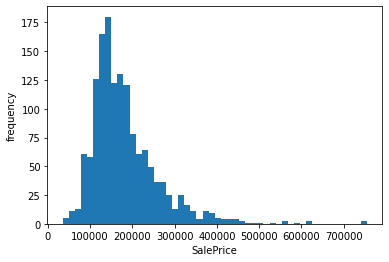

In [4]:
_ = plt.hist(data['SalePrice'], density=False, bins=50)
plt.ylabel('frequency')
plt.xlabel('SalePrice')

As shown, most of the houses cost between 100k-250k but there are some high outliers

In [5]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Find variables that have the highest correlation to 'SalePrice'

In [6]:
corrmat = data.corr().abs().unstack()['SalePrice']
corrmat = corrmat.sort_values(ascending=False)[1:6]
corrmat

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
dtype: float64

### Observe how these variables vary with 'SalePrice'

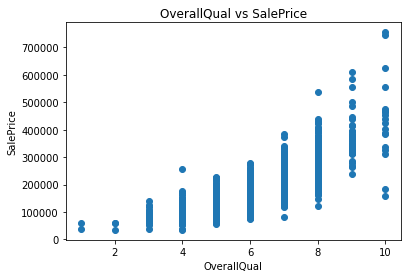

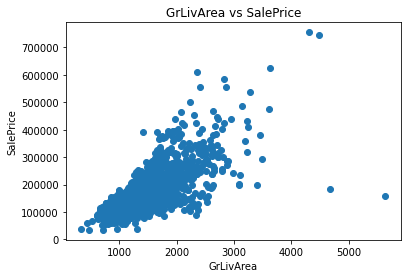

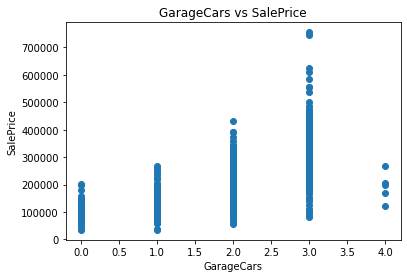

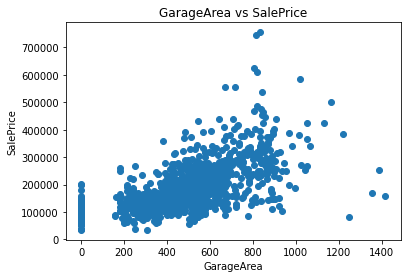

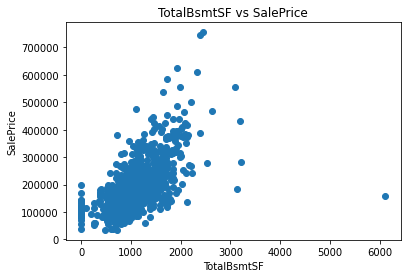

In [7]:
def plot(field):
    plt.scatter(data[field], data['SalePrice'])
    plt.title(f'{field} vs SalePrice')
    plt.xlabel(field)
    plt.ylabel('SalePrice')
    plt.show()

plot('OverallQual')
plot('GrLivArea')
plot('GarageCars')
plot('GarageArea')
plot('TotalBsmtSF')


The variables are linearly distributed, with the exception of some outliers. Therefore, a linear regression model should be able to approximate the function that maps these variables to 'SalePrice'.

### Standardize data

We will standardize the data to a mean of 0 and an sd of 1 wih the equation below:

$$x'= \frac{x - \mu}{\sigma}$$

where $\mu$ is the mean and $\sigma$ is the standard deviation. This will help the model converge better.

In [8]:
inputs = data[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']].to_numpy()
outputs = data['SalePrice'].to_numpy()

inputs = (inputs - inputs.mean()) / inputs.std()

train_x, test_x = inputs[:1200], inputs[1200:]
train_y, test_y = outputs[:1200], outputs[1200:]

# Build the model

The linear regression model used can be thought of as a single neuron with a linear activation function.

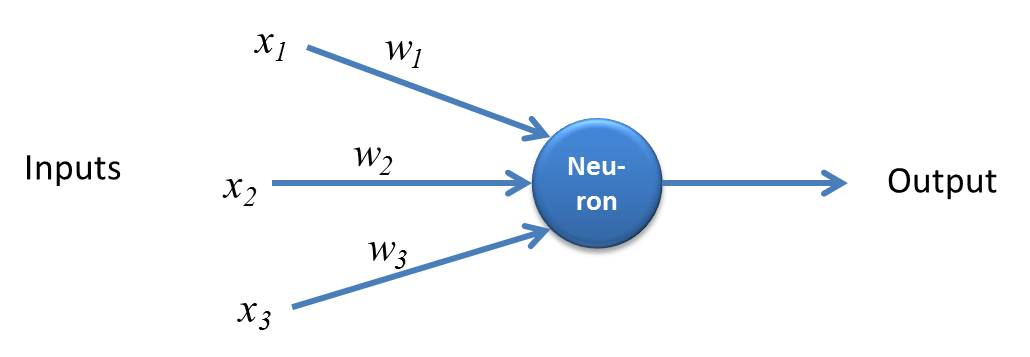

### Helper functions

In [9]:
def get_batch(batch_size=-1, set="Train"):
    if set == "Train":
        batch_size = train_y.shape[0] if batch_size == -1 else batch_size
        indices = np.random.randint(train_y.shape[0], size=batch_size)
        return train_x[indices], np.expand_dims(train_y[indices], -1)

    elif set == "Test":
        batch_size = test_y.shape[0] if batch_size == -1 else batch_size
        indices = np.random.randint(test_y.shape[0], size=batch_size)
        return test_x[indices], np.expand_dims(test_y[indices], -1)

### Model

In [10]:
class Model:
    def __init__(self, num_inputs):
        self.W = np.random.randn(num_inputs).reshape([num_inputs, 1]) # weights
        self.B = np.random.randn(1) # bias term
        self.loss_history = [] 

    def predict(self, x):
        # as in every neural network,
        # z = Wx + B
        # and y = activation(z)
        # which in this case is basically z since a linear activation function is used

        # the expected shape of x is [batch_size, num_inputs]
        return np.matmul(x, self.W) + self.B  # y = z = Wx + B

    def loss(self, y, y_hat):
        # we will use the quadratic cost function, 1/2n · ∑(y - ŷ)²
        # since in this case n = 1 (the output is one field), the function becomes 1/2 · (y - ŷ)²

        return np.square(y - y_hat)/2.

    def gradient_descent_step(self, x, y_hat, lr):
        # applies a single stochastic gradient descent (SGD) step across an entire mini-batch
        batch_size = y_hat.shape[0]

        # W' = W - lr * (1/n · ∑(∂L/∂W)) and
        # B' = B - lr * (1/n · ∑(∂L/∂B)) where lr is the learning rate, W is the weight, B is the bias, and L is the loss

        # first, we find how the loss varies with respect to the model's parameters, ∂L/∂W and ∂L/∂B
        # this is the gradient of the loss function we used earlier, L = 1/2 · (y - ŷ)²
        # taking derivatives, ∂L/∂y = y - ŷ ------------------------------------(i)
        
        # let us find ∂L/∂W
        # from the chain rule, we know that ∂L/∂W = ∂L/∂y * ∂y/∂W --------------(ii)
        # and y = Wx + B
        # taking derivatives, ∂y/∂W = x ----------------------------------------(iii)
        # substituting eqn(i) and eqn(iii) in eqn(ii), ∂L/∂W = (y - ŷ) * x
        y = self.predict(x)
        gradient_l_w = x * (y - y_hat)
        
        # now let's find ∂L/∂B
        # from the chain rule, ∂L/∂B = ∂L/∂y * ∂y/∂B ---------------------------(iv)
        # and y = Wx + B
        # taking derivatives, ∂y/∂B = 1 ----------------------------------------(v)
        # substituting eqn(1) and eqn(v) in  eqn (iv), ∂L/∂B = (y - ŷ) * 1
        gradient_l_b = y - y_hat

        # let us apply SGD on a mini-batch
        # W' = W - lr * (1/n · ∑(∂L/∂W))
        self.W -= lr * np.expand_dims(np.mean(gradient_l_w, axis=0), -1)  #average ∂L/∂W across the mini-batch then multiply by learning rate

        # B' = B - lr * (1/n · ∑(∂L/∂B))
        self.B -= lr * np.mean(gradient_l_b, axis=0)

    def fit(self, batch_size=-1, iterations=1000, lr=0.01):
        print("Training...")
        for i in tqdm(range(iterations)):
            x, y_hat = get_batch(batch_size)
            y = self.predict(x)
            loss = np.mean(self.loss(y, y_hat))  # find loss at this point
            self.loss_history.append(loss)

            self.gradient_descent_step(x, y_hat, lr) # apply one step of SGD
            

# Train the model

### Fit model with default hyperparameters

In [11]:
model = Model(5)
model.fit()

 51%|█████▏    | 514/1000 [00:00<00:00, 5136.04it/s]

Training...


100%|██████████| 1000/1000 [00:00<00:00, 5014.41it/s]


### Observe how the loss varied with each iteration

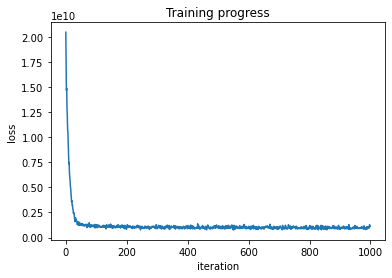

In [12]:
plt.plot(model.loss_history)
plt.title("Training progress")
plt.ylabel("loss")
plt.xlabel("iteration")
plt.show()

As we can see, the model is converging and the loss is now at a local minimum

# Make predictions with the model

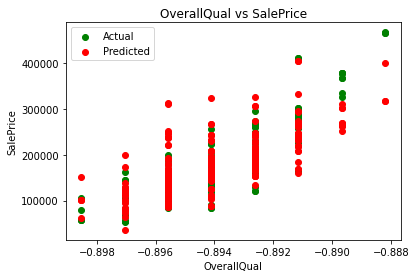

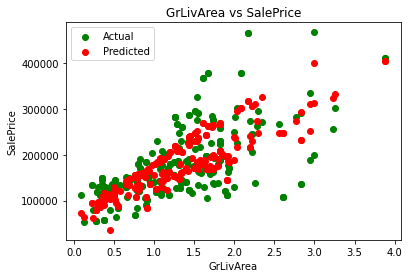

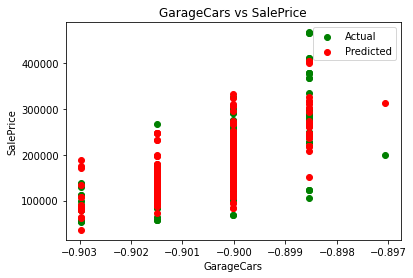

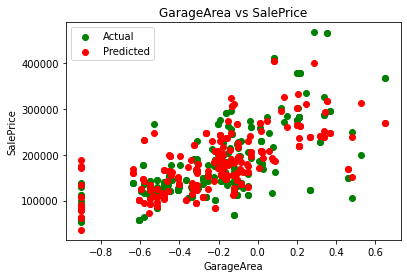

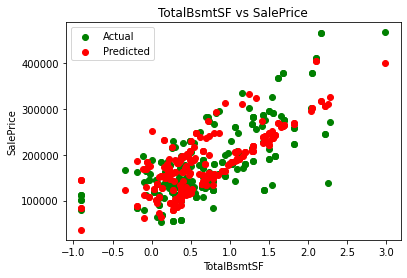

In [13]:
def plot(x, y, y_hat, name_x):
    plt.scatter(x, y_hat, color='g')
    plt.scatter(x, y, color='r')
    plt.legend(['Actual', 'Predicted'])
    plt.title(f"{name_x} vs SalePrice")
    plt.xlabel(name_x)
    plt.ylabel('SalePrice')
    plt.show()

x, y_hat = get_batch(-1, "Test")
y = model.predict(x)

field_names = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
for i in range(x.shape[-1]):
    plot(x[:, i], y[:, 0], y_hat[:, 0], field_names[i])

As the figures show, our linear regression algorithm has modeled the function quite well and is able to predict most values correctly.